In [73]:
import itertools
import sympy as sm
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants as con
from matplotlib_inline.backend_inline import set_matplotlib_formats
from qutip import qeye, sigmax, sigmay, sigmaz, tensor, create, destroy
from qutip import fidelity, tracedist

plt.style.use('seaborn-v0_8')
plt.rcParams |= {
    'text.usetex': False,
    'figure.figsize': (12, 4)
}
set_matplotlib_formats('svg', 'pdf')

In [2]:
# https://mareknarozniak.com/2020/10/14/jordan-wigner-transformation/
def Is(i, levels=2): return [qeye(levels) for j in range(0, i)]
def Sx(N, i): return tensor(Is(i) + [sigmax()] + Is(N - i - 1))
def Sy(N, i): return tensor(Is(i) + [sigmay()] + Is(N - i - 1))
def Sz(N, i): return tensor(Is(i) + [sigmaz()] + Is(N - i - 1))
def I(N): return Sz(N, 0)*Sz(N, 0)

def osum(lst): 
    return np.sum(np.array(lst, dtype=object))

def oprd(lst, d=None):
    if len(lst) == 0:
        return d
    p = lst[0]
    for U in lst[1:]:
        p = p*U
    return p

# N is the exponent, L is the length of the chain
def opow(L, op, N): return oprd([op for i in range(N)])

def commutator(A, B):
    return A*B - B*A

def anticommutator(A, B):
    return A*B + B*A

def gamma_a(N, n, Opers=None):
    Sa, Sb, Sc = Sz, Sx, Sy
    if Opers is not None:
        Sa, Sb, Sc = Opers
    return oprd([Sb(N, j) for j in range(n)], d=I(N)) * Sa(N, n)

def gamma_b(N, n, Opers=None):
    Sa, Sb, Sc = Sz, Sx, Sy
    if Opers is not None:
        Sa, Sb, Sc = Opers
    return oprd([Sb(N, j) for j in range(n)], d=I(N)) * Sc(N, n)

## measurement-only braiding, symbolisim

In [3]:
N = 6
S_num = 8
Ss = [sm.symbols(f"S_{i}") for i in range(1,S_num+1)]
gammas = [sm.symbols(f'\gamma_{i}') for i in range(1, N+1)]
M = sm.symbols('M')

def prj_meas(i, j, s):
    return (1 + sm.I * Ss[s-1] * gammas[i-1] * gammas[j-1])

In [4]:
meas_eq = sm.Eq(M, prj_meas(2, 3, 1) * prj_meas(4, 5, 2)
                 * prj_meas(1, 2, 3) * prj_meas(3, 4, 4)
                 * prj_meas(2, 4, 5) * prj_meas(3, 6, 6)
                 * prj_meas(2, 3, 7) * prj_meas(4, 5, 8))
meas_eq

Eq(M, (I*S_1*\gamma_2*\gamma_3 + 1)*(I*S_2*\gamma_4*\gamma_5 + 1)*(I*S_3*\gamma_1*\gamma_2 + 1)*(I*S_4*\gamma_3*\gamma_4 + 1)*(I*S_5*\gamma_2*\gamma_4 + 1)*(I*S_6*\gamma_3*\gamma_6 + 1)*(I*S_7*\gamma_2*\gamma_3 + 1)*(I*S_8*\gamma_4*\gamma_5 + 1))

In [5]:
def calc_prj_meas(Ss):
    return (
        (1 + 1j * Ss[0] * gamma_b(3, 0) * gamma_a(3, 1))
        * (1 + 1j * Ss[1] * gamma_b(3, 1) * gamma_a(3, 2))
        * (1 + 1j * Ss[2] * gamma_a(3, 0) * gamma_b(3, 0))
        * (1 + 1j * Ss[3] * gamma_a(3, 1) * gamma_b(3, 1))
        * (1 + 1j * Ss[4] * gamma_b(3, 0) * gamma_b(3, 1))
        * (1 + 1j * Ss[5] * gamma_a(3, 1) * gamma_b(3, 2))
        * (1 + 1j * Ss[6] * gamma_b(3, 0) * gamma_a(3, 1))
        * (1 + 1j * Ss[7] * gamma_b(3, 1) * gamma_a(3, 2))
    )

# making edges are the same fermion, to take prtial trace esaily.
def calc_prj_meas(Ss, N=3):
    assert len(Ss) == 2**N
    return (
          (1 + 1j * Ss[0] * gamma_a(N, 1) * gamma_b(N, 1))
        * (1 + 1j * Ss[1] * gamma_a(N, 2) * gamma_b(N, 2))
        
        * (1 + 1j * Ss[2] * gamma_a(N, 0) * gamma_a(N, 1))
        * (1 + 1j * Ss[3] * gamma_b(N, 1) * gamma_a(N, 2))
                                      
        * (1 + 1j * Ss[4] * gamma_a(N, 1) * gamma_a(N, 2))
        * (1 + 1j * Ss[5] * gamma_b(N, 1) * gamma_b(N, 0))
        
        * (1 + 1j * Ss[6] * gamma_a(N, 1) * gamma_b(N, 1))
        * (1 + 1j * Ss[7] * gamma_a(N, 2) * gamma_b(N, 2))
    )

def fid(matrix1, matrix2):
    vec1 = np.array(matrix1).flatten()
    vec2 = np.array(matrix2).flatten()
    
    if  not (np.linalg.norm(vec1) and np.linalg.norm(vec2)):
        return 0.0
    vec1 /= np.linalg.norm(vec1)
    vec2 /= np.linalg.norm(vec2)

    return np.round(np.abs(np.vdot(vec1, vec2))**2, 15)

In [6]:
def get_gamma(N, i):
    if i == 0:
        return gamma_a(N, 0)
    
    if i == 2 * N - 1:
        return gamma_b(N, 0)
    
    ferm_i = int(np.ceil(i/2)) - 1
    return gamma_b(N, ferm_i) if i % 2 == 0 else gamma_a(N, ferm_i)
    

def get_prj_meas(N=3) -> np.array:
    assert N > 3
    fres = []

    # generate step 1
    res = []
    for i in range(1, 2*N-1, 2):
        res.append([i, i + 1])
    fres.append(res)
    
    # generate step 2
    res = []
    mid = N-2 if N%2==0 else N-1
    idx = 0
    while idx < 2*N - 4:
        res.append([idx, idx + 1]) 
        if idx == mid - 2:
            idx += 1
            res.append([idx + 1, 2 * N - 3])
        idx += 2
    fres.append(res)
        
    # generate step 3
    res = []
    mid = N-1 if N%2==0 else N-2
    idx = 1
    while idx < 2*N - 4:
        res.append([idx, idx + 1])
        if idx == mid - 2:
            idx += 1
            res.append([idx + 1, 2 * N - 3])
        idx += 2 
    res.append([idx, 2*N -1])
    fres.append(res)
        
    # generate step 4, same as step 1
    res = []
    for i in range(1, 2*N-1, 2):
        res.append([i, i + 1])
    fres.append(res)

    return np.array(fres)

In [72]:
def calc_prj_meas(Ss, N):
    pairs = get_prj_meas(N)
    a, b, c = pairs.shape
    assert len(Ss) == a*b
    pairs = pairs.reshape((a * b, c))
    
    res = I(N)    
    for i in range(a*b):
        il, ir = pairs[i]
        res *= (1 + Ss[i] * 1j  * get_gamma(N, il) * get_gamma(N, ir))
    
    return res

def calc_prj_meas_t(Ss, N, t):
    pairs = get_prj_meas(N)
    a, b, c = pairs.shape
    assert len(Ss) == a*b
    pairs = pairs.reshape((a * b, c))
    
    res = I(N)    
    for i in range(a*b):
        il, ir = pairs[i]
        res *= (t * 1j * Ss[i] * get_gamma(N, il) * get_gamma(N, ir)).expm()
    
    return res

In [60]:
%%time
N = 4
combinations = tuple(itertools.product([1, -1], repeat=(N-1)*4))

CPU times: user 1.3 ms, sys: 0 ns, total: 1.3 ms
Wall time: 1.33 ms


In [61]:
calc_prj_meas(combinations[0], N)

Quantum object: dims = [[2, 2, 2, 2], [2, 2, 2, 2]], shape = (16, 16), type = oper, isherm = False
Qobj data =
[[32.+32.j  0. +0.j 32.+32.j  0. +0.j 32.+32.j  0. +0.j 32.+32.j  0. +0.j
  32.+32.j  0. +0.j 32.+32.j  0. +0.j 32.+32.j  0. +0.j 32.+32.j  0. +0.j]
 [ 0. +0.j 32.+32.j  0. +0.j 32.+32.j  0. +0.j 32.+32.j  0. +0.j 32.+32.j
   0. +0.j 32.+32.j  0. +0.j 32.+32.j  0. +0.j 32.+32.j  0. +0.j 32.+32.j]
 [32.+32.j  0. +0.j 32.+32.j  0. +0.j 32.+32.j  0. +0.j 32.+32.j  0. +0.j
  32.+32.j  0. +0.j 32.+32.j  0. +0.j 32.+32.j  0. +0.j 32.+32.j  0. +0.j]
 [ 0. +0.j 32.+32.j  0. +0.j 32.+32.j  0. +0.j 32.+32.j  0. +0.j 32.+32.j
   0. +0.j 32.+32.j  0. +0.j 32.+32.j  0. +0.j 32.+32.j  0. +0.j 32.+32.j]
 [32.+32.j  0. +0.j 32.+32.j  0. +0.j 32.+32.j  0. +0.j 32.+32.j  0. +0.j
  32.+32.j  0. +0.j 32.+32.j  0. +0.j 32.+32.j  0. +0.j 32.+32.j  0. +0.j]
 [ 0. +0.j 32.+32.j  0. +0.j 32.+32.j  0. +0.j 32.+32.j  0. +0.j 32.+32.j
   0. +0.j 32.+32.j  0. +0.j 32.+32.j  0. +0.j 32.+32.j  0. +0.j 32.+3

In [62]:
braiding = (gamma_a(3, 0) * gamma_b(3, 0) * np.pi/4).expm()
br = braiding.ptrace(0)

fid(br, br)

1.0

In [63]:
%%time
fids = np.zeros(len(combinations), dtype='complex')
brdp = braiding.ptrace(0)
for i in range(len(combinations)):
    fids[i] = fid(brdp, calc_prj_meas(combinations[i], N).ptrace(0))

CPU times: user 3min 33s, sys: 74.4 ms, total: 3min 33s
Wall time: 3min 35s


In [64]:
max_indices = np.where(fids == fids.max())
len(fids[max_indices]), len(fids)

(256, 4096)

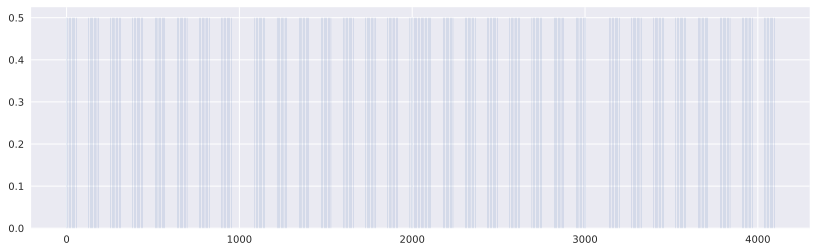

In [65]:
plt.bar(np.arange(len(combinations)), abs(fids))
plt.show()

In [66]:
%%time
brdp = braiding.ptrace(0)
nrange = range(4, 15)
fids = []
for n in nrange:
    fids.append(fid(brdp, calc_prj_meas([1]*(n-1)*4, n).ptrace(0)))

CPU times: user 1min 18s, sys: 10.2 s, total: 1min 28s
Wall time: 1min 28s


In [67]:
fids

[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

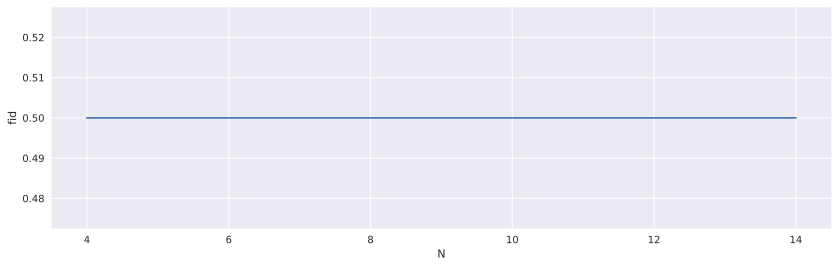

In [70]:
plt.plot(nrange, fids)
plt.xlabel('N')
plt.ylabel('fid')
plt.show()

## evolution of time

In [77]:
%%time
time = np.arange(1000)
brdp = braiding.ptrace(0)
fids = []
N = 4
for t in time:
    fids.append(fid(brdp, calc_prj_meas_t([1]*(N-1)*4, N, t).ptrace(0)))

/tmp/ipykernel_4793/3240060065.py:37: RuntimeWarning: invalid value encountered in divide
  vec2 /= np.linalg.norm(vec2)


CPU times: user 4min 59s, sys: 3min 46s, total: 8min 45s
Wall time: 2min 13s


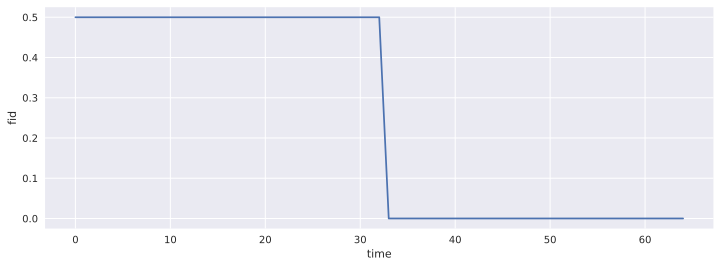

In [79]:
plt.plot(time, fids)
plt.xlabel('time')
plt.ylabel('fid')
plt.show()

## Visualization of Dots

In [36]:
class KitaevTJunction:
    def __init__(self, N: int):
        assert N > 1 and isinstance(N, int)
        self.N = N
        
    @property
    def config(self):
        ''' N is number of pairs of
        Majorona fermions'''
        x = list(range(2 * (self.N-1)))
        y = [0] * len(x)

        # middle pair
        mid = x[-1] / 2
        x += [mid, mid]
        y += [-1, -2]

        return [x, y]

    @staticmethod
    def _split_list(input_list, chunk_size):
        """Split a list into a list of lists with a specified chunk size."""
        return [input_list[i:i + chunk_size] for i in range(0, len(input_list), chunk_size)]

    def plot_config(self, ax=None):
        if ax is None:
            ax = plt.gca()
        ax.scatter(*self.config)

    def plot_measurements(self, step=1, ax=None):
        x, y = self.config
        if ax is None:
            ax = plt.gca()
        
        if step in [1, 4]:
            ax.plot(x[-2:], y[-2:], c='b')
            x = x[:-2]; y = y[:-2]
            for i in range(1, 2*self.N, 2):
                s = slice(i, i+2)
                ax.plot(x[s], y[s], c='b')
            
        elif step == 2:
            mid = x[-1]
            x = x[:-3]; y = y[:-3]
            x += [mid]; y += [-1]
            for i in range(0, 2*self.N, 2):
                s = slice(i, i+2)
                ax.plot(x[s], y[s], c='b')
        
        elif step == 3:
            mid = x[-1]
            x = x[:-3]; y = y[:-3]
            x += [mid]; y += [-1]
            print(x, y)
            for i in range(1, 2*self.N, 2):
                s = slice(i, i+2)
                ax.plot(x[s], y[s], c='b')
        
        else:
            raise ValueError("`step` must be integer within [1, 4]")
            

        ax.set_title(f"Step {step} Measurements")
        ax.set_xticks([])
        ax.set_yticks([])

[0, 1, 2, 1.5] [0, 0, 0, -1]


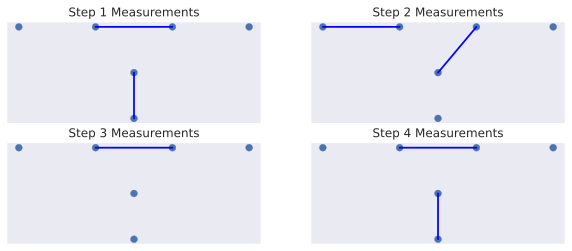

In [42]:
kitaev = KitaevTJunction(3)

fig, axes = plt.subplots(2, 2, figsize=(10, 4))
axes = axes.flatten()

for i in range(4):
    kitaev.plot_config(axes[i])
    kitaev.plot_measurements(i+1, axes[i])

plt.show()